# Project 2 - Autonomous Driving

By Laura Madrid & Lucas Noritomi-Hartwig

Autonomous driving is one of the major research venues these days. A lot of 
effort is devoted to it by both the academics as well as industry. In this 
project you'll familiarize yourself with some of the most important problems 
that arise in the field of autonomous driving.

The input to your algorithm is a stereo image pair and the camera parameters. 
You will also have available a set of training images where the cars have been 
annotated with 2D bounding boxes as well as viewpoint. Furthermore, you'll have 
a few images where the road has been annotated. Here are the tasks to solve:

In [22]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [23]:
def sum_of_square_diff(image_1_patch, image_2_patch) -> float:
    """
    Calculate the sum of squared differences between individual pixels.
    
    Args:
        image_1_patch (numpy.ndarray): Pixel block from left image.
        image_2_patch (numpy.ndarray): Pixel block from right image.
        
    Returns:
        float: Sum of absolute differences between the two pixel blocks.
    """
    if image_1_patch.shape != image_2_patch.shape:
        return -1

    return np.sum(np.sqrt(np.square(image_1_patch - image_2_patch)))

In [24]:
def compare_blocks(y, x, block_left, right_array, block_size=5, search_block_size=56):
    """
    Compare a block from the left image with blocks in the right image to find 
    the best match.
    
    Args:
        y (int): Row index of the left block.
        x (int): Column index of the left block.
        block_left (numpy.ndarray): Pixel block from the left image.
        right_array (numpy.ndarray): Entire right image.
        block_size (int): Size of the block. Defaults to 5.
        search_block_size (int): Size of the search block in the right image. Defaults to 56.

    Returns:
        tuple: (y, x) indices of the best matching block in the right image.
    """
    # Define search range for the right image
    x_min = max(0, x - search_block_size)
    x_max = min(right_array.shape[1], x + search_block_size)

    # Initialize the minimum sum of absolute differences (SAD) and its index
    min_ssd, min_index = float("inf"), None

    # Iterate through the search range in the right image
    for x in range(x_min, x_max):
        block_right = right_array[y:y + block_size, x:x + block_size]
        ssd = sum_of_square_diff(block_left, block_right)

        # Update the min sum of squared differences and its index accordingly
        if ssd < min_ssd:
            min_ssd, min_index = ssd, (y, x)

    return min_index

In [25]:
def calculate_disparity_and_depth_map(focal_length, baseline, left_array, 
                                      right_array, block_size=7, 
                                      search_block_size=56):
    """
    Calculate the disparity map between two images using block matching.

    Args:
        left_array (numpy.ndarray): Left image.
        right_array (numpy.ndarray): Right image.
        block_size (int): Size of the block. Defaults to 7.
        search_block_size (int): Size of the search block. Defaults to 56.
    Returns:
        numpy.ndarray: Disparity map.
    """
    h, w = left_array.shape
    disparity_map = np.zeros((h, w))
    depth_map = np.zeros((h, w))

    # Iterate over the entire image except for the borders
    for y in tqdm(range(block_size, h - block_size)):
        for x in range(block_size, w - block_size):
            block_left = left_array[y:y + block_size, x:x + block_size]
            min_index = compare_blocks(y, x, block_left, right_array, 
                                       block_size, search_block_size)
            disparity_map[y, x] = abs(min_index[1] - x)
            depth_map[y, x] = focal_length * baseline / disparity_map[y, x]

    return disparity_map, depth_map

In [26]:
# Visualize the disparity map
def visualize_disparity_map(disparity_map):
    """
    Visualizes the disparity map using a color map.

    Args:
        disparity_map (numpy.ndarray): The disparity map to visualize.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(disparity_map, cmap='jet')
    plt.colorbar(label='Disparity')
    plt.title('Disparity Map')
    plt.show()

In [27]:
# Visualize the depth map
def visualize_depth_map(depth_map):
    """
    Visualizes the depth map using a color map.

    Args:
        depth_map (numpy.ndarray): The depth map to visualize.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(depth_map, cmap='jet')
    plt.colorbar(label='Depth')
    plt.title('Depth Map')
    plt.show()

  0%|          | 0/361 [00:00<?, ?it/s]/var/folders/wg/mnn7ls5j0nz1vchp1r094d740000gn/T/ipykernel_40867/2515258860.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  depth_map[y, x] = focal_length * baseline / disparity_map[y, x]
100%|██████████| 361/361 [02:29<00:00,  2.41it/s]


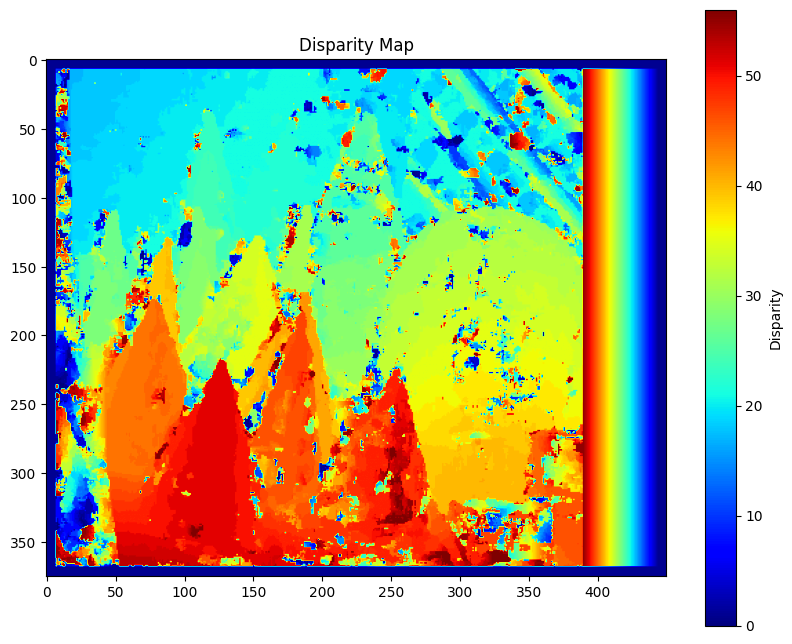

In [28]:
# Load images
left_img = cv2.imread('left.png', cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread('right.png', cv2.IMREAD_GRAYSCALE)

# Set block size and search range
block_size = 7
search_range = 56

# Camera parameters
focal_length = 1.7  # milimetres
baseline_distance = 100  # milimetres

# Compute disparity map
disparity_map, depth_map = calculate_disparity_and_depth_map(
    focal_length, baseline_distance, left_img, right_img, block_size, 
    search_range)

# Visualize the computed disparity map
visualize_disparity_map(disparity_map)

# Visualize the computed depth map
visualize_disparity_map(disparity_map)

# Visualize the computed depth map
visualize_depth_map(depth_map)